In [7]:
using Interpolations, Plots

We define the mixture setting variable $m$, with $m=0$ corresponding to best economy, $m = 0.5$ to best power and $m = 1$ to full rich.

We need the function $\pi / \pi_{pow} = f(m)$, that is, the ratio between normalized power $\pi$ for a given $(m, n, \delta, \mu)$ and the normalized power $\pi_{pow}$ for $(m=0.5, n, \delta, \mu)$.

We also need $SFC / SFC_{pow} = g(m)$, that is, the ratio between the specific fuel consumption $SFC$ for a given $(m, n, \delta, \mu)$ and the specific fuel consumption $SFC_{pow}$ for $(m=0.5, n, \delta, \mu)$. 

Both of these are given by Figure 3.1. To use it, we first define the linear relationship between x axis length (as measured in the PDF, in mm) and our newly defined variable $m$. For this we have two points: $(x = 0, m = 0)$, $(x = 99.25, m = 1)$. So:

For the linear relationship between y axis length and $f$, we have two points: $(y = 84, f = 0.86)$, $(y = 110, f = 1)$. So:

For the linear relationship between y axis length and $g$, we can get one value of $g$ from Fig. 3-5. For example, for 2400 rpm and 120 hp, $SFC_{pow} = SFC(m=0.5) = 60.8 / 120 lb/h/hp$ and $SFC_{eco} = SFC(m=0) = 51.5/120 lb/h/hp$, so $g(0) = 51.5/60.8 = 0.85$. And the other value is simply $g(0.5) = SFC(m=0.5) / SFC_{pow} = 1$, which is true by definition. The resulting two points are $(y = 4.29, g = 0.85)$, $(y = 20.12, g = 1)$.

In [2]:
x2m(x) = x/99.25
y2f(y) = 0.86 + (1-0.86)*(y-84)/(110-84)
y2g(y) = 0.85 + (1 - 0.85)*(y - 4.29)/(20.12 - 4.29)

y2g (generic function with 1 method)

In [3]:
y2f(101.01)
y2g(6.45)

0.8704674668351232

In [20]:
x_data = [0, 7.08, 13.61, 27.92, 39.87, 46.82, 53.76, 63.21, 80.99, 99.33]
m_data = x_data |> x2m

y_f_data = [83.95, 97.15, 102.71, 108.03, 109.8, 110.5, 109.8, 108.9, 105.56, 100.73]
f_data = y2f.(y_f_data)
y_g_data = [6.43, 4.29, 4.76, 9.64, 15.84, 20.12, 24.53, 31.15, 45.79, 65.26]
g_data = y2g.(y_g_data)


π_ratio = LinearInterpolation(m_data, f_data, extrapolation_bc = Flat())
sfc_ratio = LinearInterpolation(m_data, g_data, extrapolation_bc = Flat())

@show π_ratio(0.5)
@show sfc_ratio(0.5)

π_ratio(0.5) = 1.0011471403236532
sfc_ratio(0.5) = 1.0171305668476847


1.0171305668476847

Let's go to figure 3-5.

First, two points to map y-axis length to fuel consumption: $(y = 46.57, fc = 50), (y = 120.73, fc = 90)$.

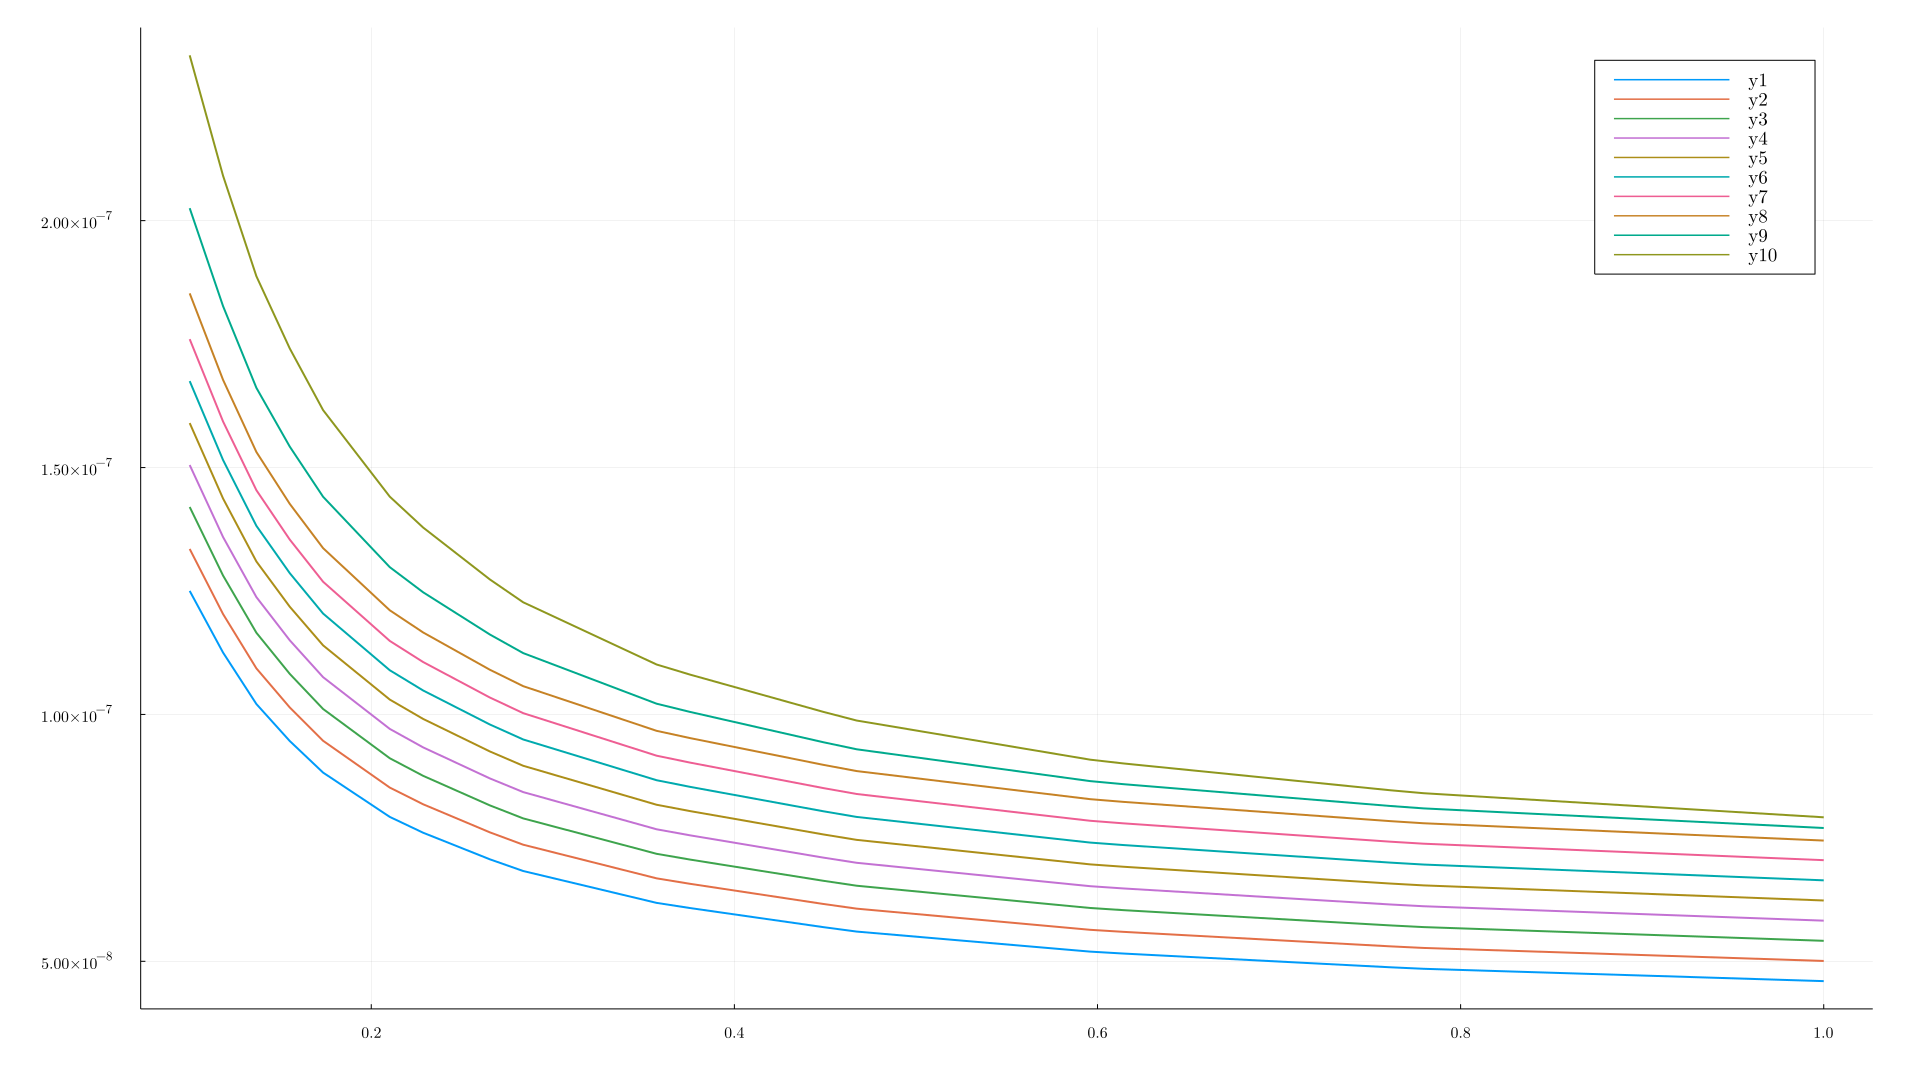

In [109]:
y2fc(y) = 50 + (90 - 50) * (y - 46.57) / (120.73 - 46.57)

n_data = [2000, 2200, 2400, 2600, 2700] / 2700
π_data = [0.45, 1]

y_data = [ 37.93  109.14
           41.78  116.6
           45.73  121.65
           48.82  125.1
           52.65  127.43]

fc_data = y2fc.(y_data)
fc_data *= 0.454 / 3600 #convert lb/h to kg/s

fc_interp = LinearInterpolation((n_data, π_data), fc_data, extrapolation_bc = Line())

π_knots = 10 .^ range(-1, 0, length = 10)
P_knots = π_knots * 200 #hp
P_knots *= 745.7 #to W

sfc_data = Array{Float64, 2}(undef, length(n_data), length(π_knots))
for (i, n) in enumerate(n_data)
    fc_knots = fc_interp(n, π_knots)
    sfc_data[i, :] = fc_knots ./ P_knots #compute sfc for this n over P
end

# @show sfc_data #this is now in kg/s/W

# plot(π_knots, sfc_data')

sfc_interp = LinearInterpolation((n_data, π_knots), sfc_data, extrapolation_bc = Line())

n_plot = range(0.2, 1, length = 10)
π_plot = range(0.1, 1, length = 50)
plot(π_plot, sfc_interp(n_plot, π_plot)')

# @show n_data
# @show π_knots
# @show sfc_data

In [129]:
#now we have all we need. let's run an example
n_val = 0.7
m_val = 0.1

#power output for best power mixture setting
π_pow = 0.6
#actual power output, accounting for mixture setting
@show π_actual = π_pow * π_ratio(m_val) #correct pow
#sfc if the actual power output were obtained with best power mixture setting
@show sfc_pow = sfc_interp(n_val, π_actual)
#actual sfc, accounting for mixture setting
@show sfc_actual = sfc_pow * sfc_ratio(m_val) #kg/s/W

P_rated = 200 * 745.7 #W
@show P_actual = π_actual * P_rated #W
@show fuel_flow = sfc_actual * P_actual #kg/s
@show fuel_flow_per_h = fuel_flow * 3600

π_actual = π_pow * π_ratio(m_val) = 0.5663328019790316
sfc_pow = sfc_interp(n_val, π_actual) = 7.80311301602294e-8
sfc_actual = sfc_pow * sfc_ratio(m_val) = 6.647829311752149e-8
P_actual = π_actual * P_rated = 84462.87408715277
fuel_flow = sfc_actual * P_actual = 0.005614947701114053
fuel_flow_per_h = fuel_flow * 3600 = 20.21381172401059


20.21381172401059

In [ ]:
1.1835e-7 * π_actual * P_rated